### Python imports

In [1]:
import xarray as xr
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import sleep
from functools import partial
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
import numcodecs
import zarr
import matplotlib.pyplot as plt
# !pip install seawater
import seawater

### Fargate cluster

In [2]:
# import dask.dataframe as dd
# from distributed import Client
# import dask
# import zarr

# from dask_cloudprovider.aws import FargateCluster
# cluster = FargateCluster(image="ghcr.io/vietnguyengit/nc2zarr:main", scheduler_timeout="60 minutes", task_role_arn="arn:aws:iam::615645230945:role/ManualDaskZarrCreation",
#                          scheduler_cpu=4096, scheduler_mem=30720)

In [3]:
# %%time
# from dask.distributed import Client
# client = Client(cluster)
# display(client)

### Inputs

In [4]:
import io
import boto3
from botocore import UNSIGNED
from botocore.config import Config

def read_dataset_inmemory(s3_path: str) -> xr.Dataset:
    """Read a NetCDF as an XArray using in-memory data"""
    try:
        with io.BytesIO() as inmemoryfile:
            # Use boto to download a file to memory
            s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
            bucket, key = s3_path.replace("s3://", "").split("/", 1)
            s3.download_fileobj(bucket, key, inmemoryfile)
            inmemoryfile.seek(0)

            return xr.open_dataset(inmemoryfile)
    except ValueError as e:
        print(f"Failed to open the file with error: {e}")
        return None

In [5]:
input_paths = []
glob_result = s3.glob('s3://imos-data/IMOS/Argo/dac/csiro/7900911/profiles/*.nc')
input_paths.extend(['s3://' + path for path in glob_result])

### Argo Processor

**Source notebook**
https://medium.com/@nicolasmortimer/argo-floats-zarr-and-pangeo-d74fc6d4ce35

*Written by Nicolas Mortimer*

In [6]:
data_types ={'CONFIG_MISSION_NUMBER':'float32','CYCLE_NUMBER':'float32','DATA_CENTRE':'|U2','DATA_MODE':'|U1',
             'DATA_STATE_INDICATOR':'|U4','DC_REFERENCE':'|U32','DIRECTION':'|U1','FIRMWARE_VERSION':'|U32',
             'FLOAT_SERIAL_NO':'|U32','JULD':'float32','JULD_LOCATION':'float32','JULD_QC':'|U1','LATITUDE':'float32',
             'LONGITUDE':'float32','PI_NAME':'|U64','PLATFORM_NUMBER':'|U8','PLATFORM_TYPE':'|U32','POSITIONING_SYSTEM':'|U8',
             'POSITION_QC':'|U1','PRES':'float32','PRES_ADJUSTED':'float32','PRES_ADJUSTED_ERROR':'float32',
             'PRES_ADJUSTED_QC':'|U1','PRES_QC':'|U1','PROFILE_PRES_QC':'|U1','PROFILE_PSAL_QC':'|U1','PROFILE_TEMP_QC':'|U1',
             'PROJECT_NAME':'|U64','PSAL':'float32','PSAL_ADJUSTED':'float32','PSAL_ADJUSTED_ERROR':'float32',
             'PSAL_ADJUSTED_QC':'|U1','PSAL_QC':'|U1','TEMP':'float32','TEMP_ADJUSTED':'float32','TEMP_ADJUSTED_ERROR':'float32',
             'TEMP_ADJUSTED_QC':'|U1','TEMP_QC':'|U1','VERTICAL_SAMPLING_SCHEME':'|U256','WMO_INST_TYPE':'|U4'}

data_levels =['PRES','PRES_ADJUSTED','PRES_ADJUSTED_ERROR','PRES_ADJUSTED_QC','PRES_QC','PSAL','PSAL_ADJUSTED',
              'PSAL_ADJUSTED_ERROR','PSAL_ADJUSTED_QC','PSAL_QC','TEMP','TEMP_ADJUSTED','TEMP_ADJUSTED_ERROR',
              'TEMP_ADJUSTED_QC','TEMP_QC']

def process_mf(dsinput,levels,data_types=data_types,data_levels=data_levels):
    ds = xr.Dataset()
    dims =('N_PROF','N_LEVELS')
    # The number of profiles is indicated by the N_PROF dimension
    # The number of pressure levels is indicated by the N_LEVELS dimension
    pading =xr.DataArray(np.ones((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))) *np.nan,dims=dims)
    pad_qc = xr.DataArray(np.chararray((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))),dims=dims)
    pad_qc[:] = b' '
    for varname in data_types.keys():
        if varname in dsinput.data_vars:
            da = dsinput[varname]
            if 'N_LEVELS' in da.dims:   
                if varname in dsinput.data_vars:
                    if varname.endswith('QC'):
                        da = xr.concat([dsinput[varname],pad_qc],dim='N_LEVELS').astype(data_types[varname])
                    else:
                        da = xr.concat([dsinput[varname],pading],dim='N_LEVELS').astype(data_types[varname])
            else:
                da = dsinput[varname].astype(data_types[varname])
        else:
            if varname in data_levels:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones((len(dsinput.N_PROF),levels), dtype='float32')*np.nan , name=varname, dims=['N_PROF','N_LEVELS'])
                else:
                    p=np.chararray((len(dsinput.N_PROF),levels))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF','N_LEVELS'])
            else:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones(len(dsinput.N_PROF), dtype="float32")*np.nan , name=varname, dims=['N_PROF'])
                else:
                    p=np.chararray((len(dsinput.N_PROF)))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF'])
        if not ('HISTORY' in varname) and ('N_CALIB' not in da.dims) and ('N_PARAM' not in da.dims) and  ('N_PROF' in da.dims):
                ds[varname]= da
    return ds.chunk({'N_LEVELS':levels})
   
preproc = partial(process_mf,levels=3000)

# uncomment @dask.delayed if using cluster
# @dask.delayed 
def process_float(s3_uri):
    file = read_dataset_inmemory(s3_uri)
    data = preproc(file)
    return data

#### Export to Zarr function

In [7]:
def export_zarr(store, dataset, overwrite):
    if overwrite:
        dataset.to_zarr(store, mode='w', consolidated=True)
    else:
        dataset.to_zarr(store, mode='a', append_dim='N_PROF', consolidated=True)

### Generate dataset and export to Zarr

In [8]:
%%time
store = '/home/ec2-user/SageMaker/nc2zarr/notebooks/combined_argo.zarr/'
# store= s3fs.S3Map(root=f's3://imos-data-pixeldrill/viet-test/new_argo.zarr', s3=s3, check=False)
for i in tqdm(range(len(input_paths))):
    ds = process_float(input_paths[i])
    overwrite = True if i == 0 else False
    export_zarr(store, ds, overwrite)
    
print('=============== Finished ===============')

100%|██████████| 49/49 [23:01<00:00, 28.20s/it]  

=============== Finished ===============
CPU times: user 2min 51s, sys: 6.04 s, total: 2min 57s
Wall time: 23min 1s


### Open zarr

In [9]:
%%time
data = xr.open_zarr('s3://imos-data-pixeldrill/viet-test/new_argo.zarr')
# data = xr.open_zarr('/home/ec2-user/SageMaker/nc2zarr/notebooks/combined_argo.zarr/')
data

CPU times: user 136 ms, sys: 4.12 ms, total: 140 ms
Wall time: 166 ms


<xarray.Dataset>
Dimensions:                   (N_PROF: 49, N_LEVELS: 3000)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/40)
    CONFIG_MISSION_NUMBER     (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CYCLE_NUMBER              (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_CENTRE               (N_PROF) <U2 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_MODE                 (N_PROF) <U1 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_STATE_INDICATOR      (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>
    DC_REFERENCE              (N_PROF) <U32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                        ...
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_QC                   (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 dask.array<chunksize=(1,), meta=np.ndarray>
    WMO_INST_TYPE             (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>

#### Function for converting JULD value into readable datetime
*Credit: Alex Leith AODN*

In [10]:
from datetime import datetime

def np_dt64_to_dt(in_datetime: np.datetime64) -> str:
    """Convert numpy datetime64 to datetime"""
    dt = datetime.fromtimestamp(in_datetime.astype(int) / 1e9)
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

### Plotting

**Source:**
https://datalab.marine.rutgers.edu/2020/11/introduction-to-python-argo-float-data/

*Written by Sage Lichtenwalner, Rutgers University, June 9, 2020*

#### Profile Plot

CPU times: user 24.5 ms, sys: 8.01 ms, total: 32.5 ms
Wall time: 110 ms


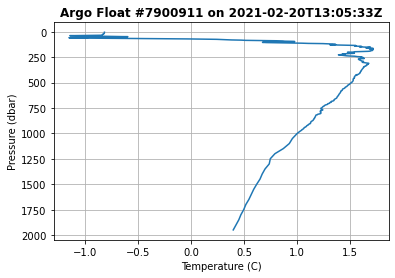

In [11]:
%%time
# Profile Plot
nprof = 0 #Specify a profile to plot
plt.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])

plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');
plt.gca().invert_yaxis() #Flip the y-axis

CPU times: user 86.5 ms, sys: 4.24 ms, total: 90.7 ms
Wall time: 443 ms


Text(0.5, 0.98, 'Argo #7900911')

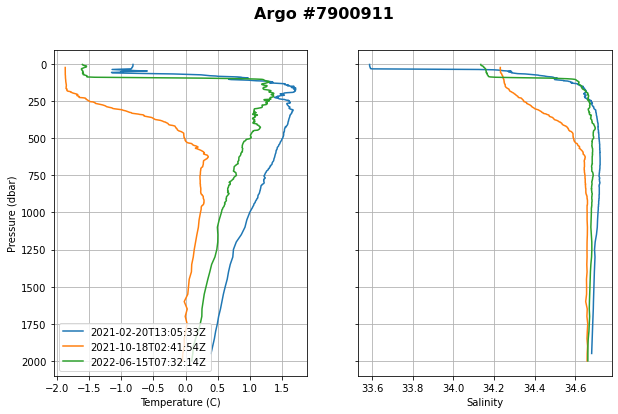

In [12]:
%%time
# Profile Plot
# Subplot example
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(10,6))

nprof = 0 # First profile
ax1.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof], label=np_dt64_to_dt(data.JULD[nprof].values))
ax2.plot(data.PSAL_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])

nprof = round(len(input_paths) / 2) # Middle-ish profile
ax1.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof], label=np_dt64_to_dt(data.JULD[nprof].values))
ax2.plot(data.PSAL_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])

nprof = -1 # Last profile
ax1.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof], label=np_dt64_to_dt(data.JULD[nprof].values))
ax2.plot(data.PSAL_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])

ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Temperature (C)')
ax2.set_xlabel('Salinity')
ax1.invert_yaxis()
ax1.legend()

# Add some gridlines
ax1.grid()
ax2.grid()

# Add a super title
fig.suptitle('Argo #%d' % data.PLATFORM_NUMBER[nprof].values, fontweight='bold', fontsize=16);

#### TS Diagram

CPU times: user 60.1 ms, sys: 0 ns, total: 60.1 ms
Wall time: 302 ms


Text(0.5, 1.0, 'Argo Float #7900911 on 2021-10-18T02:41:54Z')

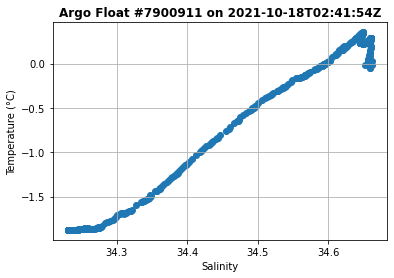

In [13]:
%%time
nprof = round(len(input_paths) / 2) #Selected profile
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof])
plt.xlabel('Salinity')
plt.ylabel('Temperature (°C)')
plt.grid()

plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');

#### T-S Diagram with depth

CPU times: user 79.1 ms, sys: 88 µs, total: 79.1 ms
Wall time: 382 ms


Text(0.5, 1.0, 'Argo Float #7900911 on 2021-10-18T02:41:54Z')

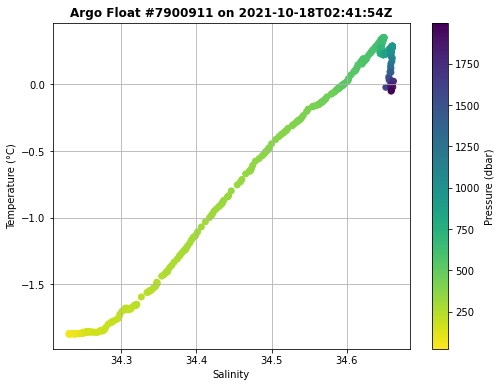

In [14]:
%%time
plt.figure(figsize=(8,6))

nprof = round(len(input_paths) / 2) #Selected profile
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof], c=data.PRES_ADJUSTED[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')

cbh = plt.colorbar();
cbh.set_label('Pressure (dbar)')

plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');

#### Float Track Map

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator


CPU times: user 1.62 s, sys: 65 ms, total: 1.69 s
Wall time: 2.08 s


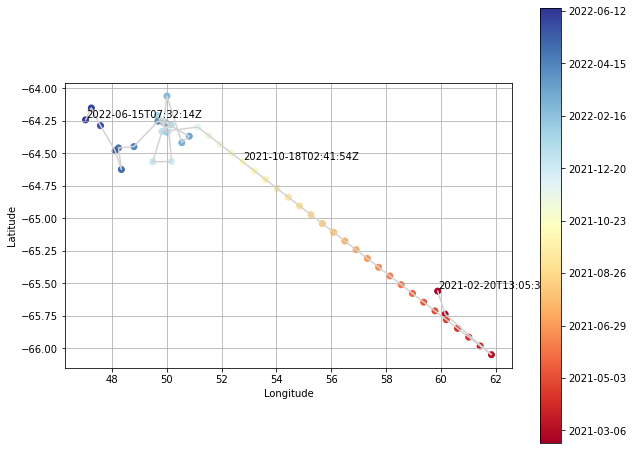

In [15]:
%%time
# Simple map of a float track
plt.figure(figsize=(10,8))
plt.plot(data.LONGITUDE, data.LATITUDE, c='lightgrey')
plt.scatter(data.LONGITUDE, data.LATITUDE, c=data.JULD, cmap='RdYlBu')

# Crude profile labels
for nprof in [0, round(len(input_paths) / 2), -1]:
    plt.text(data.LONGITUDE[nprof]+.02, data.LATITUDE[nprof]+.02, np_dt64_to_dt(data.JULD[nprof].values))

# Add a colorbar
cbar = plt.colorbar();
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
# Set the aspect ratio to pseudo-Mercator
plt.gca().set_aspect(2 / np.cos(np.deg2rad( np.mean(plt.ylim()) )))